In [7]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime

from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn import metrics
from sklearn.linear_model import LinearRegression

import pickle

import json

In [8]:
# reading in train and test datasets
train_df = pd.read_csv('../data/train_origin.csv')
test_df = pd.read_csv('../data/test.csv')

# summing up duration-related columns to use as target variable 
train_df['Total_Duration'] = train_df['Administrative_Duration'] + train_df['Informational_Duration'] + train_df['ProductRelated_Duration']
test_df['Total_Duration'] = test_df['Administrative_Duration'] + test_df['Informational_Duration'] + test_df['ProductRelated_Duration']                      

In [5]:
# removing irrelevant columns (including columns that are considered as real-time information)
train_df = train_df.drop(columns=['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated','ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'Revenue'])

test_df = test_df.drop(columns=['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'Revenue'])

In [6]:
# dropping duplicate values
print('train_df shape before dropping duplicates: ', train_df.shape)
train = train_df.drop_duplicates()
print('train_df shape after dropping duplicates: ', train.shape)
print('test_df shape before dropping duplicates: ', test_df.shape)
test = test_df.drop_duplicates()
print('test_df shape after dropping duplicates: ', test.shape)

train_df shape before dropping duplicates:  (8631, 67)
train_df shape after dropping duplicates:  (8520, 67)
test_df shape before dropping duplicates:  (3699, 67)
test_df shape after dropping duplicates:  (3673, 67)


In [7]:
# separating the target variable
X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
X_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1]
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (8520, 66)
y_train shape:  (8520,)
X_test shape:  (3673, 66)
y_test shape:  (3673,)


In [8]:
# obtaining validation set
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('X_train_ shape: ', X_train_.shape)
print('y_train_ shape: ', y_train_.shape)
print('X_val shape: ', X_val.shape)
print('y_val shape: ', y_val.shape)

X_train_ shape:  (6816, 66)
y_train_ shape:  (6816,)
X_val shape:  (1704, 66)
y_val shape:  (1704,)


In [9]:
# define relu function to be used on the predictions
def relu(x):
    return np.maximum(0,x)

In [10]:
# define empty dataframe used to store metrics values for the different models
score_df = pd.DataFrame()
score_df.index = ['MAE', 'MSE', 'RMSE']

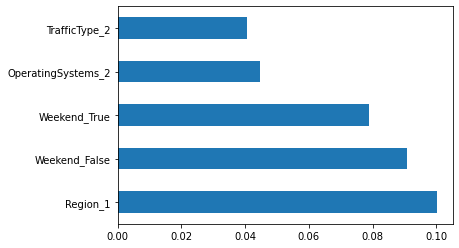

In [11]:
# creating an object of ExtraTreesRegressor class
reg = ExtraTreesRegressor()
reg.fit(X_train_,y_train_)

# getting feature importance
feat_importances = pd.Series(reg.feature_importances_, index=X_train_.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

### Decision Tree Regression

In [12]:
# obtaining the optimal columns to use for DecisionTreeRegressor
min_score = np.inf
best_num = 0
for i in range(1, X_train_.shape[1]+1):    
    impt_cols = list(feat_importances.nlargest(i).keys())
    
    # creating an object of DecisionTreeRegressor class
    reg_decision_model = DecisionTreeRegressor()
    reg_decision_model.fit(X_train_[impt_cols],y_train_)
    
    y_pred = reg_decision_model.predict(X_val[impt_cols])
    
    if mse(y_val, y_pred) < min_score:
        min_score = mse(y_val, y_pred)
        best_num = i
        print(best_num, min_score)

dt_impt_cols = list(feat_importances.nlargest(best_num).keys())

1 6.907292610251152
2 6.903718895164162
4 6.89318584435934
5 6.76110599046892
6 6.6805637017735515
7 6.660886261678447


In [13]:
dt_impt_cols

['Region_1',
 'Weekend_False',
 'Weekend_True',
 'OperatingSystems_2',
 'TrafficType_2',
 'VisitorType_Returning_Visitor',
 'Browser_4']

In [13]:
# creating an object of DecisionTreeRegressor class
reg_decision_model = DecisionTreeRegressor()

In [14]:
# parameters for grid search
parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

In [15]:
# creating an object of GridSearchCV class for hyperparameter tuning
dt_tuning_model = GridSearchCV(reg_decision_model,param_grid=parameters,scoring='neg_mean_squared_error',cv=5,verbose=3)

In [16]:
# hyperparameter tuning
%%time
%%capture
dt_tuning_model.fit(X_train_[dt_impt_cols],y_train_)

Wall time: 10min 21s


In [17]:
# best hyperparameters 
dt_tuning_model.best_params_

{'max_depth': 9,
 'max_features': 'log2',
 'max_leaf_nodes': 50,
 'min_samples_leaf': 3,
 'min_weight_fraction_leaf': 0.1,
 'splitter': 'random'}

In [18]:
dt_tuning_model.best_score_

-4.481933651598598

In [14]:
# creating an object of DecisionTreeRegressor class with optimal parameters
dt_tuned_hyper_model= DecisionTreeRegressor(max_depth=9,max_features='log2',max_leaf_nodes=50,min_samples_leaf=3,min_weight_fraction_leaf=0.1,splitter='random')

In [15]:
# fitting model to training set
dt_tuned_hyper_model.fit(X_train_[dt_impt_cols],y_train_)

DecisionTreeRegressor(max_depth=9, max_features='log2', max_leaf_nodes=50,
                      min_samples_leaf=3, min_weight_fraction_leaf=0.1,
                      splitter='random')

In [16]:
# testing the tuned model with the validation set
dt_tuned_pred_val = relu(dt_tuned_hyper_model.predict(X_val[dt_impt_cols]))

print('MAE:', metrics.mean_absolute_error(y_val,dt_tuned_pred_val))
print('MSE:', metrics.mean_squared_error(y_val, dt_tuned_pred_val))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_val, dt_tuned_pred_val)))

MAE: 1.317963049303732
MSE: 6.889988044635591
RMSE: 2.624878672364799


In [18]:
# saving validation results to score_df
score_df['DecisionTreeRegressor'] = np.array([metrics.mean_absolute_error(y_val,dt_tuned_pred_val),
                                              metrics.mean_squared_error(y_val, dt_tuned_pred_val),
                                              np.sqrt(metrics.mean_squared_error(y_val, dt_tuned_pred_val))])

### Linear Regression

In [19]:
# obtaining the optimal columns to use for LinearRegression
min_score = np.inf
best_num = 0
for i in range(1, X_train_.shape[1]+1):    
    impt_cols = list(feat_importances.nlargest(i).keys())
    
    # creating an object of LinearRegression class
    LR = LinearRegression()
    LR.fit(X_train_[impt_cols],y_train_)
    
    y_pred = LR.predict(X_val[impt_cols])
    
    if mse(y_val, y_pred) < min_score:
        min_score = mse(y_val, y_pred)
        best_num = i
        print(best_num, min_score)

lr_impt_cols = list(feat_importances.nlargest(best_num).keys())

1 6.907292610251152
2 6.904127029190034
4 6.902135240716614
5 6.7845181526576
6 6.746002907505769
7 6.739994118221701
8 6.734437354680547
9 6.710122424583445
10 6.707545330053155
11 6.706920841273918
13 6.6966049303958375
16 6.694812539252705


In [20]:
lr_impt_cols

['Region_1',
 'Weekend_False',
 'Weekend_True',
 'OperatingSystems_2',
 'TrafficType_2',
 'VisitorType_Returning_Visitor',
 'Browser_4',
 'Region_3',
 'Month_Nov',
 'OperatingSystems_1',
 'OperatingSystems_4',
 'Region_2',
 'Browser_2',
 'Month_Jul',
 'OperatingSystems_3',
 'SpecialDay']

In [21]:
# creating an object of LinearRegression class
LR = LinearRegression()

# fitting model to training set
LR.fit(X_train_[lr_impt_cols],y_train_)

LinearRegression()

In [22]:
# testing the model with the validation set
y_prediction_val = relu(LR.predict(X_val[lr_impt_cols]))

print('MAE:', metrics.mean_absolute_error(y_val,y_prediction_val))
print('MSE:', metrics.mean_squared_error(y_val, y_prediction_val))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_val, y_prediction_val)))

MAE: 1.2819118030378476
MSE: 6.694515604648001
RMSE: 2.587376200835124


In [23]:
# saving validation results to score_df
score_df['LinearRegression'] = np.array([metrics.mean_absolute_error(y_val,y_prediction_val),
                                              metrics.mean_squared_error(y_val, y_prediction_val),
                                              np.sqrt(metrics.mean_squared_error(y_val, y_prediction_val))])

### Gradient Boosting Regression

In [24]:
# obtaining the optimal columns to use for GradientBoostingRegressor
min_score = np.inf
best_num = 0
for i in range(1, X_train_.shape[1]+1):    
    impt_cols = list(feat_importances.nlargest(i).keys())
    
    # creating an object of GradientBoostingRegressor class
    reg_decision_model = GradientBoostingRegressor()
    reg_decision_model.fit(X_train_[impt_cols],y_train_)
    
    y_pred = reg_decision_model.predict(X_val[impt_cols])
    
    if mse(y_val, y_pred) < min_score:
        min_score = mse(y_val, y_pred)
        best_num = i
        print(best_num, min_score)

gbr_impt_cols = list(feat_importances.nlargest(best_num).keys())

1 6.9072927240079816
2 6.903719066775359
4 6.893185709704401
5 6.761647061614968
6 6.701824874814142
7 6.683301709122467
9 6.668712480853729
10 6.662112833186758
13 6.654150185445455
15 6.651024452197535
16 6.649185540837635
17 6.6472853441644855
40 6.642947361615867


In [25]:
gbr_impt_cols

['Region_1',
 'Weekend_False',
 'Weekend_True',
 'OperatingSystems_2',
 'TrafficType_2',
 'VisitorType_Returning_Visitor',
 'Browser_4',
 'Region_3',
 'Month_Nov',
 'OperatingSystems_1',
 'OperatingSystems_4',
 'Region_2',
 'Browser_2',
 'Month_Jul',
 'OperatingSystems_3',
 'SpecialDay',
 'Region_4',
 'TrafficType_1',
 'TrafficType_13',
 'Browser_1',
 'TrafficType_14',
 'Region_6',
 'Month_Dec',
 'Region_7',
 'Month_Sep',
 'Region_9',
 'TrafficType_3',
 'Region_5',
 'Month_Oct',
 'Region_8',
 'Browser_10',
 'Browser_6',
 'Browser_5',
 'TrafficType_6',
 'Month_May',
 'VisitorType_New_Visitor',
 'Month_June',
 'TrafficType_10',
 'Month_Mar',
 'TrafficType_4']

In [94]:
# creating an object of GradientBoostingRegressor class
reg_gradient_model = GradientBoostingRegressor()

In [95]:
# parameters for grid search
params = {"max_depth" : [1,3,5,7,9,11,12],
          "max_features":["auto","log2","sqrt",None],
          "learning_rate": [0.001,0.01,0.05,0.1],
          "loss": ['quantile'],
          "alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}

In [96]:
# creating an object of GridSearchCV class for hyperparameter tuning
gbr_tuning_model = GridSearchCV(reg_gradient_model,param_grid=params,scoring='neg_mean_squared_error',cv=5,verbose=3)

In [97]:
# hyperparameter tuning
%%time
%%capture
gbr_tuning_model.fit(X_train_[gbr_impt_cols],y_train_)

Wall time: 4h 55min 13s


In [98]:
# best hyperparameters
gbr_tuning_model.best_params_

{'alpha': 0.7,
 'learning_rate': 0.05,
 'loss': 'quantile',
 'max_depth': 5,
 'max_features': 'sqrt'}

In [99]:
gbr_tuning_model.best_score_

-4.351408481062597

In [26]:
# creating an object of GradientBoostingRegressor class with optimal parameters
gbr_tuned_hyper_model = GradientBoostingRegressor(alpha=0.7,max_features='sqrt',learning_rate=0.05,loss='quantile',max_depth=5)

In [27]:
# fitting model to training set
gbr_tuned_hyper_model.fit(X_train_[gbr_impt_cols],y_train_)

GradientBoostingRegressor(alpha=0.7, learning_rate=0.05, loss='quantile',
                          max_depth=5, max_features='sqrt')

In [28]:
# testing the tuned model with the validation set
gbr_tuned_pred_val = relu(gbr_tuned_hyper_model.predict(X_val[gbr_impt_cols]))

print('MAE:', metrics.mean_absolute_error(y_val,gbr_tuned_pred_val))
print('MSE:', metrics.mean_squared_error(y_val, gbr_tuned_pred_val))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_val, gbr_tuned_pred_val)))

MAE: 1.2741571503135958
MSE: 6.637096077176464
RMSE: 2.576256213418313


In [29]:
# saving validation results to score_df
score_df['GradientBoostingRegressor'] = np.array([metrics.mean_absolute_error(y_val,gbr_tuned_pred_val),
                                              metrics.mean_squared_error(y_val, gbr_tuned_pred_val),
                                              np.sqrt(metrics.mean_squared_error(y_val, gbr_tuned_pred_val))])

### Evaluation and Final Model

In [30]:
score_df

DecisionTreeRegressor  LinearRegression  GradientBoostingRegressor
MAE                1.317963          1.281912                   1.274157
MSE                6.889988          6.694516                   6.637096
RMSE               2.624879          2.587376                   2.576256

In [31]:
final_model = GradientBoostingRegressor(alpha=0.7,max_features='sqrt',learning_rate=0.05,loss='quantile',max_depth=5)
# fitting the model to the full train dataset
final_model.fit(X_train[gbr_impt_cols],y_train)
final_pred = relu(final_model.predict(X_test[gbr_impt_cols]))
    
print('MAE:', metrics.mean_absolute_error(y_test,final_pred))
print('MSE:', metrics.mean_squared_error(y_test, final_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, final_pred)))

MAE: 1.2561356867105453
MSE: 4.337133894901668
RMSE: 2.0825786647571487


In [33]:
# saving columns used in the model
col_dict = {'columns': gbr_impt_cols}
with open('../trained_models/stay_duration_pred.json', 'w') as f:
    json.dump(col_dict, f)

In [34]:
# save the model to disk
filename = '../trained_models/stay_duration_pred.sav'
pickle.dump(final_model, open(filename, 'wb'))
